# Importing Liberaries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('CWL.csv')
# parse strings to datetime type
dataset['Year'] = dataset['Year'].astype(str)
# df = dataset['Years'].apply(lambda x:int(x))
# df

In [3]:
dataset.head()

,Year,CWL
0,1985,15881.0
1,1986,15718.0
2,1987,15549.0
3,1988,15628.0
4,1989,15202.0


In [4]:
dataset.count()
# dataset = dataset[:-1]

Year    35
CWL     35
dtype: int64

In [5]:
dataset['Year'] = pd.to_datetime(dataset['Year'])
indexedDataset = dataset.set_index(['Year'])


In [6]:
indexedDataset.head()

,CWL
Year,
1985-01-01,15881.0
1986-01-01,15718.0
1987-01-01,15549.0
1988-01-01,15628.0
1989-01-01,15202.0


# Data Visualisation

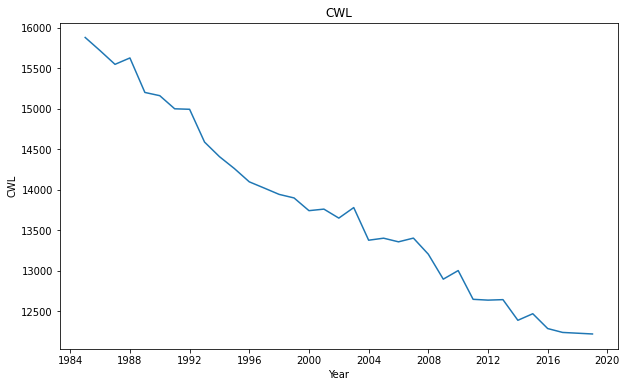

In [7]:
# draw lineplot
sns.lineplot(x="Year", y="CWL", data=dataset).set(title='CWL')
plt.show()


# Decomposing Time Series

<Figure size 720x432 with 0 Axes>

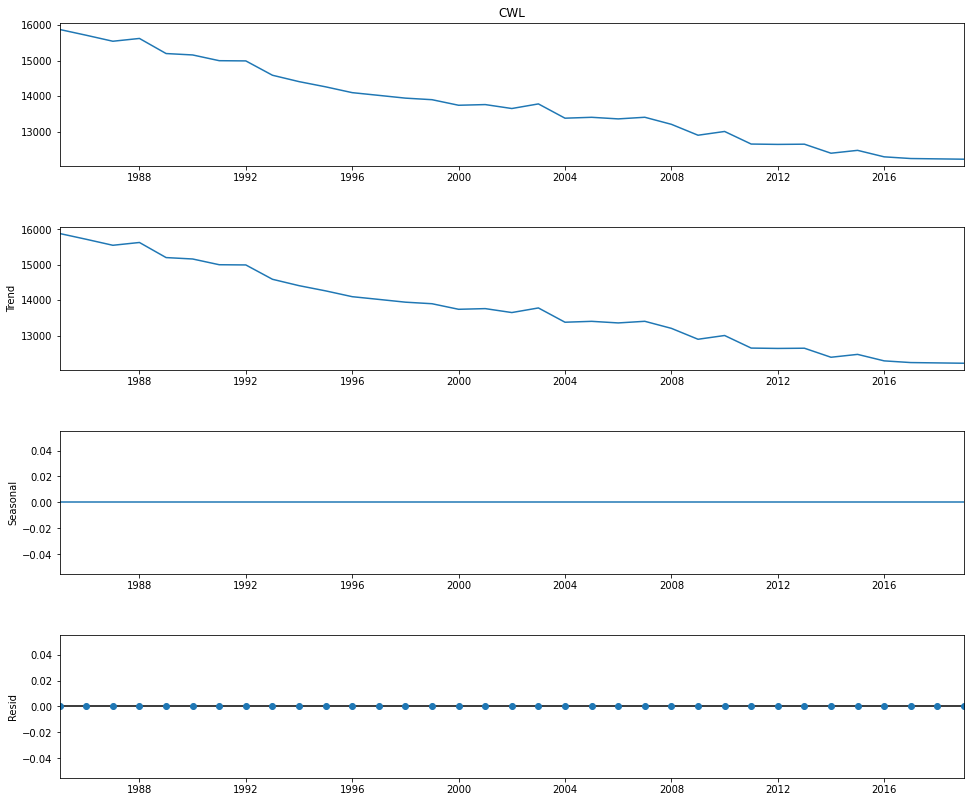

In [8]:
#Seasonal decomposition using moving averages
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(indexedDataset['CWL'], model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

# Checking Stationarity

Dickey-Fuller Test
- A stationary time series is one whose properties do not depend on the time at which the series is observed.

In [9]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(indexedDataset['CWL'])

p-value = 0.2300. The series is likely non-stationary.
Test Statistic                 -2.136707
p-value                         0.230013
#Lags Used                      1.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


- Since p value is greater than 0.05. Hence the series is non-stationary

## Converting into stationary

p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.443470e+00
p-value                        4.824908e-16
#Lags Used                     0.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


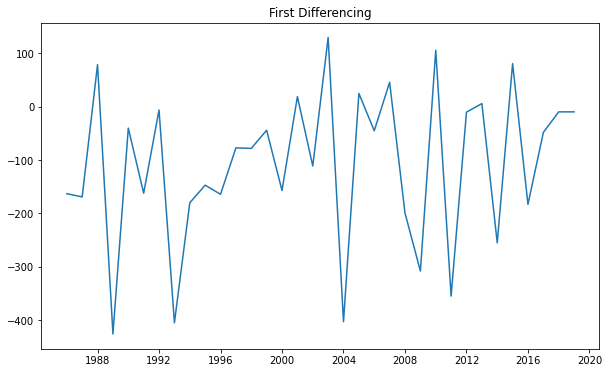

In [10]:
first_diff = indexedDataset.CWL - indexedDataset.CWL.shift(1)
plt.plot(first_diff)
plt.title("First Differencing")
first_diff = first_diff.dropna(inplace = False)
# print(first_diff.head())
dickey_fuller_test(first_diff, window = 12)

# Data Spliting

In [35]:
size = int(0.80*len(indexedDataset))
train_df = indexedDataset[:size]
test_df  = indexedDataset[size:]
length = len(indexedDataset)
length_train = len(train_df)
length_test = len(test_df)

In [36]:
train_df.count()

CWL    28
dtype: int64

In [37]:
test_df.head()

,CWL
Year,
2013-01-01,12643.0
2014-01-01,12388.0
2015-01-01,12469.0
2016-01-01,12286.0
2017-01-01,12238.0


Text(0, 0.5, 'CWL')

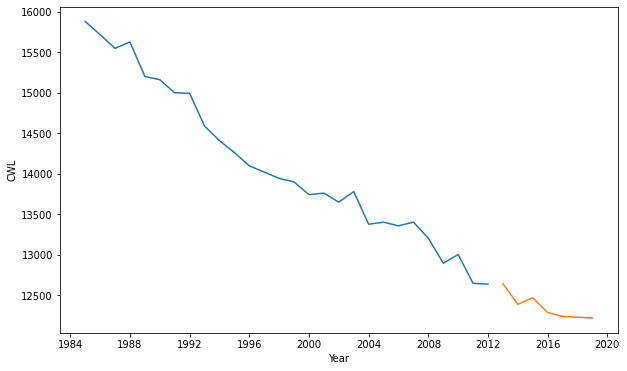

In [38]:
plt.plot(train_df)
plt.plot(test_df)
plt.xlabel('Year')
plt.ylabel('CWL')

# Ploting ACF and PACF

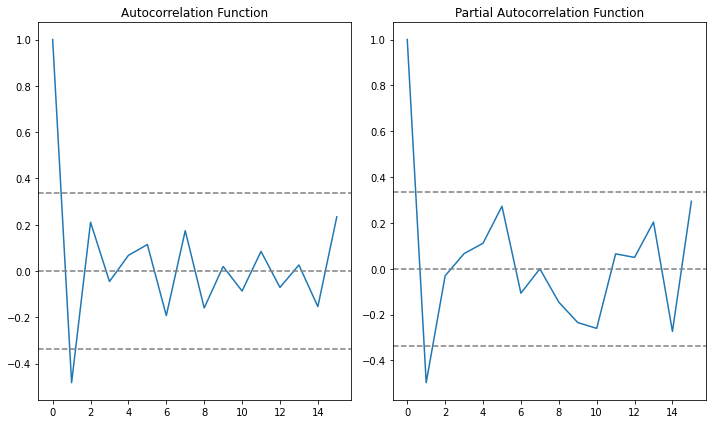

In [15]:
# an only compute partial correlations for lags up to 50% of the sample size. Hence nlag = 40//2 = 20
lag_acf = acf(first_diff,nlags=15)
lag_pacf = pacf(first_diff,nlags=15)

# The axhline() function in pyplot module of matplotlib library is used to add a horizontal line across the axis.

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray') #Formula of CI = 1.96* sqrt(n)
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

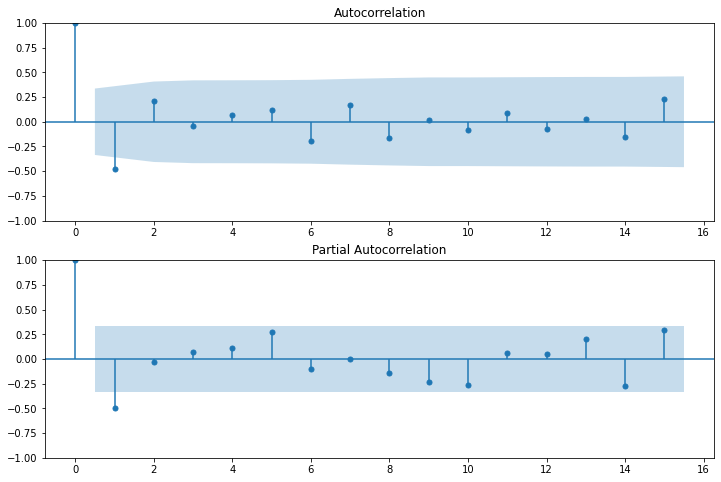

In [16]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=15, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=15, ax=ax2)

## Auto Arima for Estimating Parameters

In [39]:
from pmdarima import auto_arima

fit = auto_arima(train_df, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=352.640, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=352.310, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=346.797, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=347.895, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=363.264, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=348.759, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=348.757, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=350.756, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=365.241, Time=0.00 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.504 seconds


In [18]:
indexedDataset.head()

,CWL
Year,
1985-01-01,15881.0
1986-01-01,15718.0
1987-01-01,15549.0
1988-01-01,15628.0
1989-01-01,15202.0


# ARIMA Model

In [40]:
arima_model = sm.tsa.arima.ARIMA(endog = train_df,order=(1, 1, 0))
ar_model= arima_model.fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CWL   No. Observations:                   28
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -180.620
Date:                Tue, 22 Nov 2022   AIC                            365.241
Time:                        18:30:59   BIC                            367.833
Sample:                    01-01-1985   HQIC                           366.012
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0255      0.239     -0.107      0.915      -0.494       0.443
sigma2      3.818e+04   1.07e+04      3.578      0.000    1.73e+04    5.91e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.37   Jarque-Bera (JB):                 1.32
Prob(Q):                              0.01   Prob(JB):                         0.52
Heteroskedasticity (H):               0.93   Skew:                            -0.47
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The P-Value should be less than 0.05, ideally for the corresponding X to be significant.

## Forecast

In [50]:
start_index = length_train+1
end_index= length
predicted_arima = ar_model.predict(start = start_index, end = end_index)
print(predicted_arima.head())

2014-01-01    12637.248406
2015-01-01    12637.248572
2016-01-01    12637.248568
2017-01-01    12637.248568
2018-01-01    12637.248568
Freq: AS-JAN, Name: predicted_mean, dtype: float64


Text(0.5, 1.0, 'CWL (ARIMA)')

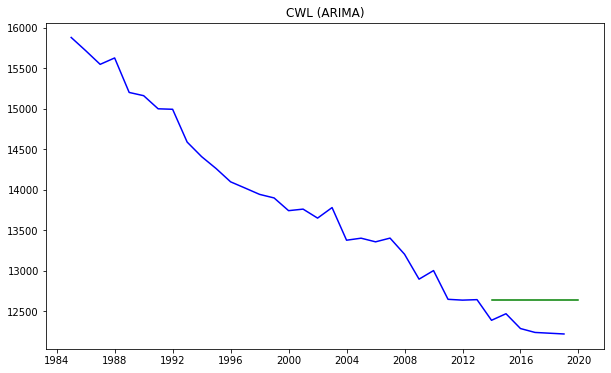

In [51]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_arima,color='green')
plt.title("CWL (ARIMA)")

In [52]:
def error(y_true, y_pred):
    mad = np.mean(abs((y_true-y_pred)))
    MSE = np.mean(np.square((y_true-y_pred)))
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('MAD: %.2f  \nRMSE: %.2f \nMAPE: %.2f'% (mad,RMSE,MAPE))

In [53]:
error(test_df["CWL"],predicted_arima)

MAD: 332.50  
RMSE: 345.26 
MAPE: 2.71


In [54]:
print(predicted_arima.head())

2014-01-01    12637.248406
2015-01-01    12637.248572
2016-01-01    12637.248568
2017-01-01    12637.248568
2018-01-01    12637.248568
Freq: AS-JAN, Name: predicted_mean, dtype: float64


## SARIMA MODEL

In [55]:
sarima_model = sm.tsa.statespace.SARIMAX(train_df, trend='t', order=(1,1,0)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                    CWL   No. Observations:                   28
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -175.477
Date:                Tue, 22 Nov 2022   AIC                            356.955
Time:                        18:33:35   BIC                            360.842
Sample:                    01-01-1985   HQIC                           358.110
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -7.7791      2.476     -3.142      0.002     -12.632      -2.926
ar.L1         -0.2856      0.196     -1.454      0.146      -0.671       0.099
sigma2      2.605e+04   7916.444      3.290      0.0

In [78]:
start_index = length_train
end_index = length+10
predicted_sarima = sarima_model.predict(start = start_index, end= end_index, typ="labels") 
print(predicted_sarima.head())

2013-01-01    12422.041192
2014-01-01    12257.842572
2015-01-01    12071.366980
2016-01-01    11883.474917
2017-01-01    11688.208314
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [79]:
# predicted_sarima.to_excel('CWL_sarima.xlsx')

In [80]:
error(test_df["CWL"],predicted_sarima)

MAD: 483.02  
RMSE: 550.19 
MAPE: 3.93


Text(0.5, 1.0, 'AREA (SARIMA)')

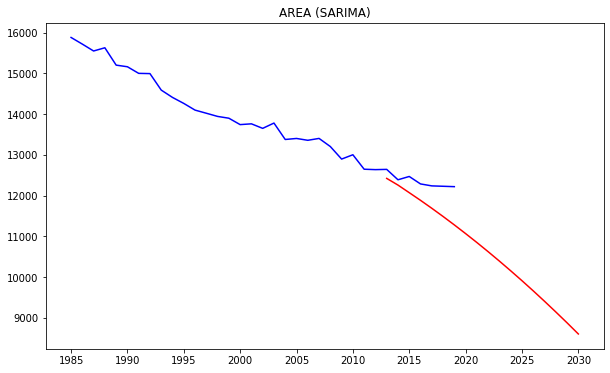

In [81]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_sarima,color='red')
plt.title("AREA (SARIMA)")

## Simple Exponential Smoothing (SES)

In [75]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
start_index = 1
end_index = length+10
predicted_ses = SimpleExpSmoothing(indexedDataset['CWL']).fit().predict(start = start_index, end= end_index)

In [76]:
error(test_df["CWL"],predicted_ses)

MAD: 84.49  
RMSE: 123.82 
MAPE: 0.68


Text(0.5, 1.0, 'AREA (SARIMA)')

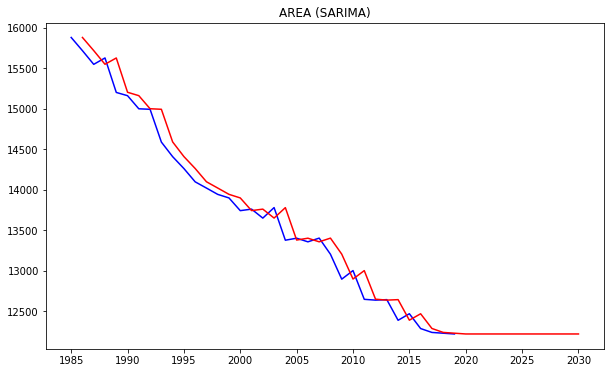

In [77]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_ses,color='red')
plt.title("AREA (SARIMA)")